# Metric Learning with ArcFace loss function
test run on cpu

参考：
- PyTorch Metric Learning: https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#arcfaceloss
- Arcfaceお試し(pytorch metric learning): https://note.com/pollenallergy/n/ne627d7d45876

In [1]:
import os
import time

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import timm
from pytorch_metric_learning import losses

import umap
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data

In [3]:
!ls ../tmp/market_metriclearning_HT

images    test.csv  train.csv


In [4]:
!ls -l ../tmp/market_metriclearning_HT/images | wc -l

   12937


In [5]:
image_dir = '../tmp/market_metriclearning_HT/images'

In [6]:
df_train = pd.read_csv('../tmp/market_metriclearning_HT/train.csv')
print(df_train.shape)
df_train.head()

(12114, 3)


,image_id,label,fold
0,0517_c5s1_143520_02.jpg,517,2
1,0816_c6s2_104418_01.jpg,816,4
2,1278_c1s6_012016_02.jpg,1278,2
3,0508_c5s2_082302_02.jpg,508,1
4,1198_c6s3_034292_01.jpg,1198,3


In [7]:
# test run用少量データ
test_idx = 0
test_classes = 10
df_train = df_train[df_train['label'].isin(df_train['label'].value_counts()[test_idx:(test_idx+test_classes)].index)]

df_train.shape

(577, 3)

In [8]:
df_train['label'].value_counts()

label
299    74
139    66
105    61
197    59
272    59
208    58
22     53
132    49
148    49
261    49
Name: count, dtype: int64

In [9]:
df_train['label'].nunique(), df_train['label'].min(), df_train['label'].max()

(10, 22, 299)

In [10]:
# pytorch学習用ラベルの作成
labels = df_train['label'].unique()
labels.sort()
id_label = {v:i for i,v in enumerate(labels)}
df_train['label_id'] = df_train['label'].map(id_label)   # label_idをtargetに利用

In [11]:
df_train

,image_id,label,fold,label_id
5,0022_c4s1_004376_03.jpg,22,2,0
10,0132_c6s1_022726_01.jpg,132,1,2
17,0197_c2s1_038751_03.jpg,197,0,5
20,0272_c6s1_057426_01.jpg,272,1,8
26,0272_c5s1_066298_01.jpg,272,0,8
...,...,...,...,...
12064,0299_c5s1_067148_02.jpg,299,3,9
12070,0197_c5s1_045301_05.jpg,197,4,5
12080,0299_c5s1_092623_01.jpg,299,1,9
12085,0197_c5s1_045151_05.jpg,197,2,5


In [12]:
df_train['label_id'].min(), df_train['label_id'].max()

(0, 9)

In [13]:
df_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')
print(df_test.shape)
df_test.head()

(1356, 2)


,image_id,label
0,0655_c5s2_037230_03.jpg,655
1,0806_c6s2_088893_10.jpg,806
2,1106_c2s2_147252_01.jpg,1106
3,1422_c3s3_057028_06.jpg,1422
4,0309_c3s1_074117_01.jpg,309


## Metric Learningの実施

In [14]:
img_size = 128
batch_size = 64
init_learning_rate = 0.0001    # 学習率（初期）

dataframe_image_col = 'image_id'
dataframe_label_col = 'label_id'

embedding_dim = 256    # 距離学習のEmbedding次元数
class_size = df_train[dataframe_label_col].nunique()    # 学習データのラベルのクラス数
print(f'class_size: {class_size}')

class_size: 10


### Augmentation, Dataset

In [15]:
transform_scoring = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),
])

In [16]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_dir, transforms, mode='train'):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_file_name = self.df.loc[index, dataframe_image_col]
        img_file_path = os.path.join(self.img_dir, img_file_name)
        target = self.df.loc[index, dataframe_label_col]
    
        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        image_transformed = self.transforms(image=image)['image']

        image_transformed = image_transformed.astype(np.float32)
        image_transformed = image_transformed.transpose(2, 0, 1)
        image_transformed /= 255.

        if self.mode == 'inference':
            return torch.tensor(image_transformed).float()
        else:   # Train/Valid/Testなど正解ラベルが必要な時
            return torch.tensor(image_transformed).float(), torch.tensor(target).long()

<__main__.CustomDataset object at 0x7f7e285e9130> 577
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 128, 128]) tensor(6)


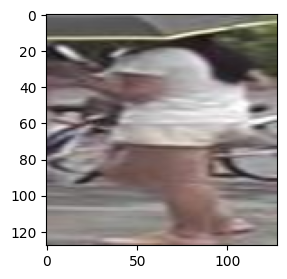

In [17]:
# Dataset test
tmp_dataset = CustomDataset(df=df_train, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(tmp_dataset, len(tmp_dataset))

tmp_img, tmp_label = tmp_dataset[10]    # 表示画像indexを指定
print(type(tmp_img), type(tmp_label))
print(tmp_img.shape, tmp_label)

plt.figure(figsize=[3,3])
plt.imshow(tmp_img.permute(1, 2, 0))
plt.show()

### Model

In [18]:
# モデルアウトプットのクラス数を、距離学習のEmbedding次元数に設定
backborn = timm.create_model('resnet18', pretrained=True, num_classes=embedding_dim)
backborn.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth',
 'hf_hub_id': 'timm/resnet18.a1_in1k',
 'architecture': 'resnet18',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [19]:
backborn.fc

Linear(in_features=512, out_features=256, bias=True)

In [20]:
# output test
# Embedding次元数が出力
backborn(torch.rand(8, 3, 328, 328)).shape

torch.Size([8, 256])

### 学習
mAPといった指標でよく精度評価が実施されたりするが実装が不明なため実施なし

In [21]:
def train_func(model, train_loader, criterion, optimizer):
    losses = []
    bar = tqdm(train_loader)
    model.train()

    for i, (images, targets) in enumerate(bar):    # バッチループ
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        #criterion = criterion.to(device)
        loss = criterion(outputs, targets)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-5:])   # 過去5バッチループのLoss平均

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train= np.mean(losses)
    return loss_train

def valid_func(model, valid_loader, criterion): 
    losses = []
    OUTPUTS, TARGETS = [], []
    bar = tqdm(valid_loader)
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            criterion = criterion.to(device)
            loss = criterion(outputs, targets)

            losses.append(loss.item())
            smooth_loss = np.mean(losses[-5:])

            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

            OUTPUTS.append(outputs.cpu())
            TARGETS.append(targets.cpu())

        loss_valid = np.mean(losses)
        
        ''' to do:  mAPの実装
        PREDS = f(OUTPUTS)
        map = mAP(TARGETS, PREDS))
        '''

    return loss_valid
    #return loss_valid, map

In [22]:
#metric = losses.ArcFaceLoss(num_classes=class_size, embedding_size=embedding_dim, scale=10, margin=0.5)
#metric

In [23]:
def run(fold):
    print('Running fold #{}'.format(fold))

    train_ = df_train[df_train['fold']!=fold]
    #train_ = df_train
    valid_ = df_train[df_train['fold']==fold]
    print(df_train.shape, train_.shape, valid_.shape)

    dataset_train = CustomDataset(df=train_, img_dir=image_dir, transforms=transform_scoring , mode='train')
    dataset_valid = CustomDataset(df=valid_, img_dir=image_dir, transforms=transform_scoring, mode='train')

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)#, num_workers=2)

    print(f'Batch size: {batch_size}')
    print('train samples:', len(dataset_train), 'valid samples:', len(dataset_valid))
    print('train batch roops:', len(train_loader), 'valid batch roops:', len(valid_loader))

    model = m.to(device)
    #print(model)
    metric = losses.ArcFaceLoss(num_classes=class_size, embedding_size=embedding_dim, scale=10, margin=0.5)
    #print(metric)
    optimizer = optim.Adam([{'params': model.parameters()}, {'params': metric.parameters()}], lr=init_learning_rate)
    #print(optimizer)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs-1, eta_min=1e-8)
    #print(scheduler)

    log = {}
    log_file = f'{exp_name}_fold{fold}_log.txt'
    model_file = os.path.join('tmp', f'{exp_name}_fold{fold}_best.pth')
    best_map = 0.0

    for epoch in range(n_epochs):
        print('>> Epoch: {}/{}'.format(epoch+1, n_epochs))

        loss_train = train_func(model, train_loader, metric, optimizer)
        print('Training:: Loss: {}'.format(loss_train))
        
        ''' to do
        loss_valid, map = valid_func(model, valid_loader, metric)
        print('Validation:: Loss: {}, mAP: {}'.format(loss_valid, map))
        '''
        loss_valid = valid_func(model, valid_loader, metric)
        print('Validation:: Loss: {}'.format(loss_valid))

        log['loss_train'] = log.get('loss_train', []) + [loss_train]
        log['loss_valid'] = log.get('loss_valid', []) + [loss_valid]
        log['lr'] = log.get('lr', []) + [optimizer.param_groups[0]["lr"]]
        ''' to do
        log['mAP'] = log.get('acc', []) + [map]
        '''

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}.'
        ''' to do
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, acc: {acc:.4f}.'
        '''
        print(content)
        with open(log_file, 'a') as fp:
            fp.write(content + '\n')

        ''' to do
        if acc > best_map:
            print(f'best_map ({best_map:.6f} --> {map:.6f}). Saving model ...')
            map_max = map
            torch.save(model.state_dict(), model_file)
        '''

        scheduler.step(epoch+1)

    torch.save(model.state_dict(), model_file.replace('_best', '_final'))
    return log

In [24]:
# Test run
n_epochs = 5

m = backborn

fold = 0
exp_name = 'TestExperiment'

tmp_log = run(fold=fold)
tmp_log

Running fold #0
(577, 4) (478, 4) (99, 4)
Batch size: 64
train samples: 478 valid samples: 99
train batch roops: 8 valid batch roops: 2
>> Epoch: 1/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 2.326584041118622


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 2.281941533088684
Mon Apr 22 14:58:43 2024 Fold 0, Epoch 0, lr: 0.0001000, loss_train: 2.32658, loss_valid: 2.28194.
>> Epoch: 2/5


/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.8980099111795425


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 2.1101924180984497
Mon Apr 22 14:59:09 2024 Fold 0, Epoch 1, lr: 0.0000854, loss_train: 1.89801, loss_valid: 2.11019.
>> Epoch: 3/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.6385419517755508


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.9977632761001587
Mon Apr 22 14:59:35 2024 Fold 0, Epoch 2, lr: 0.0000500, loss_train: 1.63854, loss_valid: 1.99776.
>> Epoch: 4/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.4987404346466064


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.9055237174034119
Mon Apr 22 14:59:59 2024 Fold 0, Epoch 3, lr: 0.0000147, loss_train: 1.49874, loss_valid: 1.90552.
>> Epoch: 5/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.4683501571416855


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.8268414735794067
Mon Apr 22 15:00:23 2024 Fold 0, Epoch 4, lr: 0.0000000, loss_train: 1.46835, loss_valid: 1.82684.


{'loss_train': [2.326584041118622,
  1.8980099111795425,
  1.6385419517755508,
  1.4987404346466064,
  1.4683501571416855],
 'loss_valid': [2.281941533088684,
  2.1101924180984497,
  1.9977632761001587,
  1.9055237174034119,
  1.8268414735794067],
 'lr': [0.0001,
  8.535680352542144e-05,
  5.0005000000000007e-05,
  1.465319647457856e-05,
  1e-08]}

## 推論（Embeddingの出力）

In [25]:
# 学習データに対する推論を実施
print(df_train.shape)
dataset_test = CustomDataset(df=df_train, img_dir=image_dir, transforms=transform_scoring, mode='train')
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

(577, 4)


In [26]:
OUTPUTS, TARGETS = [], []
bar = tqdm(test_loader)
m = m.to(device)
m.eval()

with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = m(images)
            
            OUTPUTS.append(outputs.cpu().numpy())
            TARGETS.append(targets.cpu().numpy())

OUTPUTS = np.concatenate(OUTPUTS)
TARGETS = np.concatenate(TARGETS)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
OUTPUTS.shape, TARGETS.shape

((577, 256), (577,))

In [28]:
OUTPUTS[0][:50]

array([-0.07005639,  0.25072172,  0.11933232,  0.28713843, -0.24192683,
        0.01773082, -0.36260793, -0.28959122,  0.08169556, -0.15313572,
        0.23387188, -0.12374973, -0.01150277,  0.27490482, -0.21286145,
       -0.15031546, -0.14359537,  0.25968504, -0.05144962,  0.07180111,
       -0.2271772 , -0.05016354,  0.13515335,  0.18482822,  0.17623907,
       -0.06148733,  0.09863955,  0.09271528, -0.12006368, -0.3696545 ,
       -0.0140557 , -0.4778905 , -0.23965356,  0.2885722 ,  0.03827132,
       -0.2595359 , -0.14182183, -0.2448667 , -0.22492987, -0.16403833,
        0.14536355,  0.127444  , -0.07922722, -0.13456519,  0.38957375,
        0.15640633,  0.19708143, -0.41615278, -0.05752128, -0.0485523 ],
      dtype=float32)

In [29]:
TARGETS.min(), TARGETS.max(), pd.Series(TARGETS).nunique()

(0, 9, 10)

## 可視化（UMAP）

/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_8643/87445950.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1],


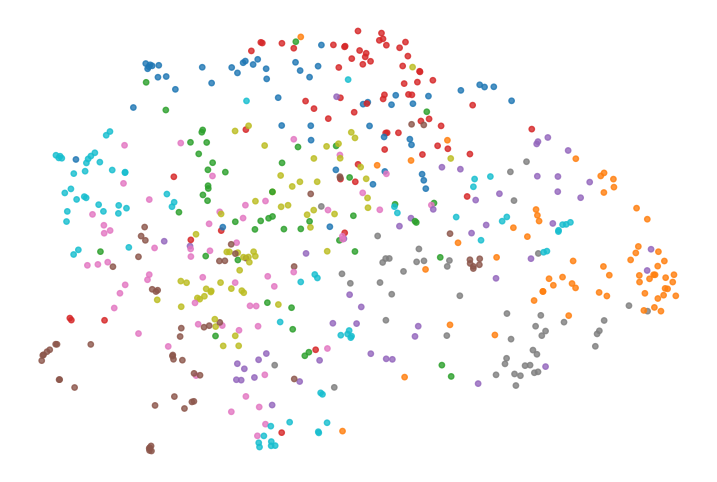

In [30]:
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(OUTPUTS)

import matplotlib.pyplot as plt 
plt.figure(figsize=(9, 6))
plt.scatter(embedding[:, 0], embedding[:, 1],
            c=[sns.color_palette()[x] for x in TARGETS], 
            #c=TARGETS,
            cmap='Spectral',
            s=15, 
            alpha=0.8)
plt.axis('off')
#plt.colorbar()
plt.show()

## 類似画像の取得
ある画像を指定し、類似したtop kを表示

In [59]:
#df_train

In [50]:
df_res = df_train.copy()
df_res = df_res.reset_index(drop=True)
df_res['img_vec'] = [i for i in OUTPUTS]
df_res

,image_id,label,fold,label_id,img_vec
0,0022_c4s1_004376_03.jpg,22,2,0,"[-0.07005639, 0.25072172, 0.11933232, 0.287138..."
1,0132_c6s1_022726_01.jpg,132,1,2,"[-0.1122462, -0.222212, 0.07584111, 0.16032279..."
2,0197_c2s1_038751_03.jpg,197,0,5,"[-0.27487323, -0.01664906, 0.20780163, -0.0815..."
3,0272_c6s1_057426_01.jpg,272,1,8,"[0.16786316, -0.10767029, 0.058295444, 0.25930..."
4,0272_c5s1_066298_01.jpg,272,0,8,"[0.03688013, -0.06559703, 0.17802468, -0.07430..."
...,...,...,...,...,...
572,0299_c5s1_067148_02.jpg,299,3,9,"[0.3681674, -0.28163874, 0.0592807, 0.02599445..."
573,0197_c5s1_045301_05.jpg,197,4,5,"[-0.109122634, 0.30546194, -0.063273825, 0.105..."
574,0299_c5s1_092623_01.jpg,299,1,9,"[0.08883697, -0.22694063, -0.044690467, 0.0709..."
575,0197_c5s1_045151_05.jpg,197,2,5,"[0.34674725, 0.3402163, 0.045425415, 0.0430879..."


In [52]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def similar_images(idx, top_k=10):
    ''' 指定したインデックスと類似した画像の検索とそれらの表示
    top_k: 上位k個の類似画像
    '''
    label = df_res.loc[idx, 'label']
    print(f'Data Index: {idx}, Label: {label}')
    base_vac = df_res.loc[idx,'img_vec']

    f = lambda x: cos_sim(base_vac, x)
    similarity = df_res['img_vec'].apply(f)

    tmp_d = df_res[['image_id','label',]].copy()
    tmp_d['similarity'] = similarity
    top_k_df = tmp_d.sort_values('similarity', ascending=False)[:top_k].reset_index(drop=True)
    display(top_k_df)
    n_same_label = sum(top_k_df['label']==label)   # top_k中、指定した画像と同じラベルの数
    print(f'Out of top {top_k}, {n_same_label} is the same label group.')
    
    
    ### プロット
    top_k_df =  top_k_df[:10]   # 10画像のみ表示
    fig = plt.figure(figsize=(60, 10))
    counter = 1
    for i, row in top_k_df.iterrows():
        im_id = row['image_id']
        im_path = os.path.join(image_dir, im_id)
        lb = row['label']
        sim = row['similarity']
        
        ax = fig.add_subplot(1, 10, counter)
        if i==0:
            title = f'Your img - ID:{lb}'
        else:
            title = f'ID:{lb}, Sim:{sim:.3f}'
        ax.set_title(title, fontsize=30)
        im = cv2.imread(im_path)
        converted_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(converted_im)
        counter = counter + 1
    
    return None

Data Index: 0, Label: 22


,image_id,label,similarity
0,0022_c4s1_004376_03.jpg,22,1.000000
1,0132_c5s1_023176_02.jpg,132,0.518604
2,0299_c5s2_143774_04.jpg,299,0.496327
3,0299_c5s2_143774_04.jpg,299,0.496327
4,0022_c5s1_002526_01.jpg,22,0.493625
5,0105_c6s1_017501_03.jpg,105,0.482959
6,0197_c2s1_044926_02.jpg,197,0.479615
7,0197_c2s1_044926_02.jpg,197,0.479615
8,0299_c5s1_067223_02.jpg,299,0.475751
9,0261_c5s1_060723_02.jpg,261,0.473091


Out of top 10, 2 is the same label group.


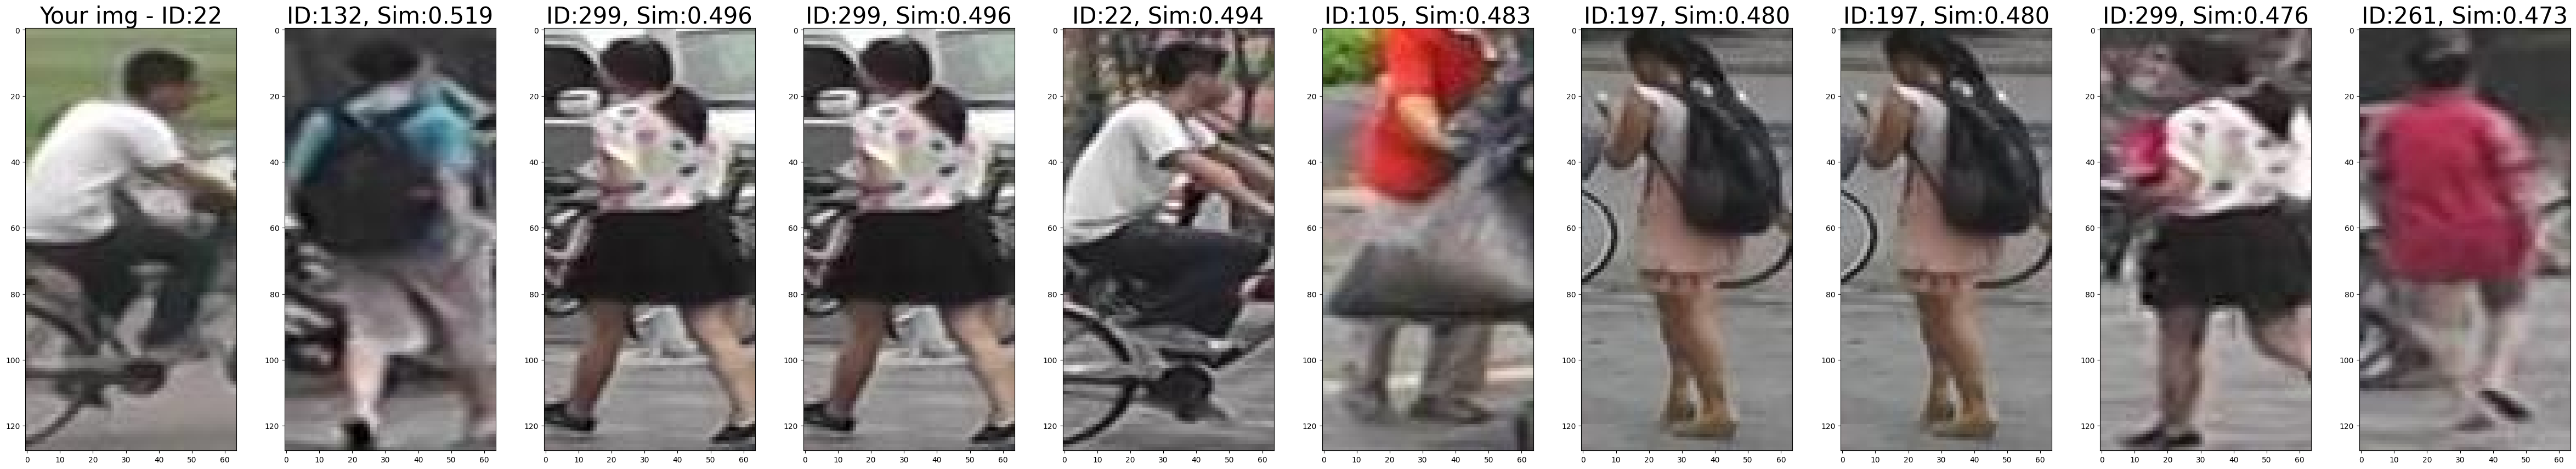

In [53]:
similar_images(idx=0, top_k=10)

Data Index: 100, Label: 208


,image_id,label,similarity
0,0208_c4s1_041726_03.jpg,208,1.000000
1,0208_c1s1_042176_03.jpg,208,0.604019
2,0299_c1s5_008111_01.jpg,299,0.589781
3,0208_c1s1_045426_01.jpg,208,0.579920
4,0208_c2s2_094482_01.jpg,208,0.572507
5,0139_c5s1_075723_03.jpg,139,0.564907
6,0197_c4s1_062932_02.jpg,197,0.555352
7,0197_c4s1_062932_02.jpg,197,0.555352
8,0272_c5s1_065948_01.jpg,272,0.554905
9,0299_c3s2_143269_04.jpg,299,0.554489


Out of top 10, 4 is the same label group.


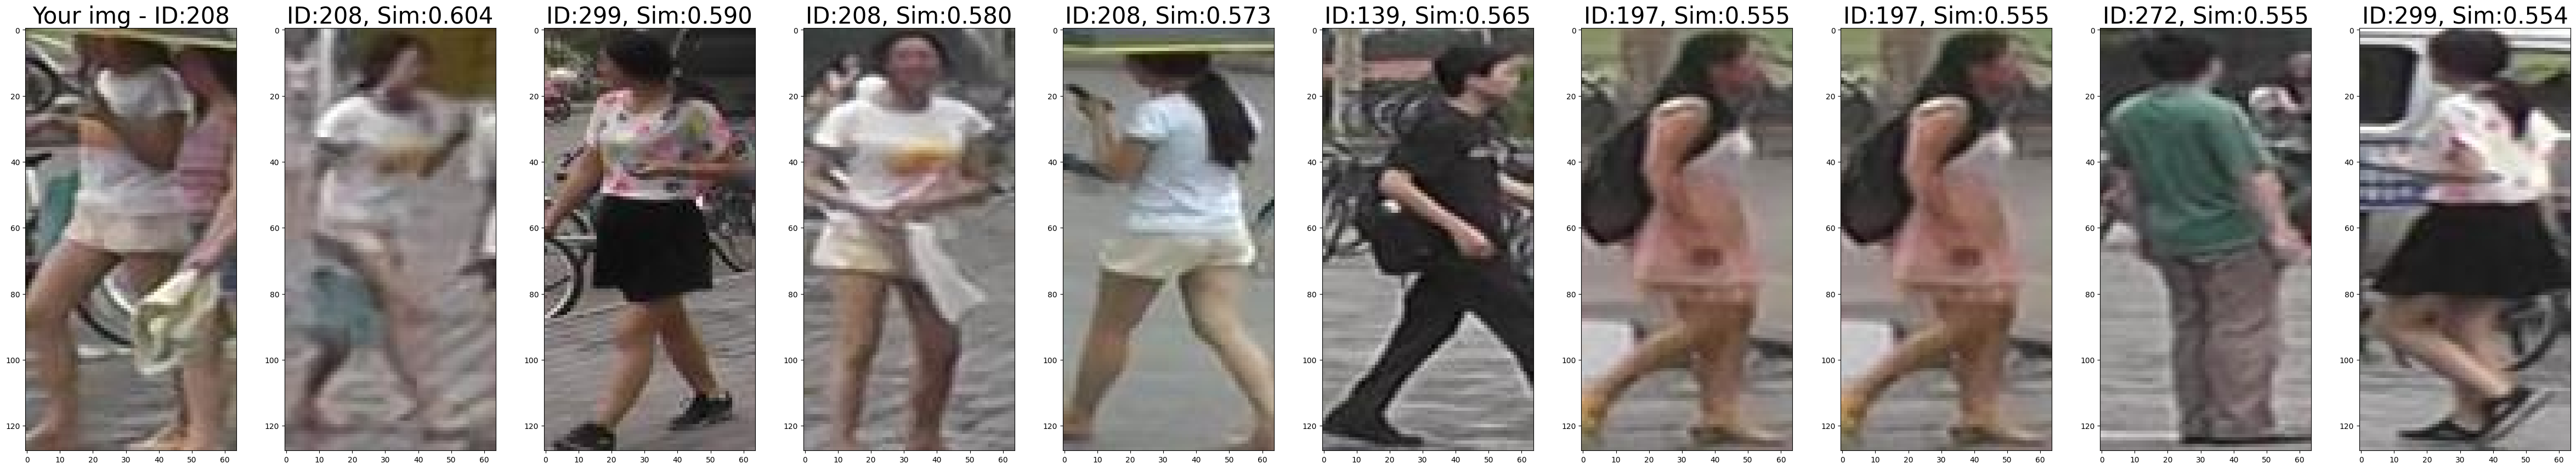

In [54]:
similar_images(idx=100, top_k=10)

Data Index: 50, Label: 299


,image_id,label,similarity
0,0299_c1s2_019691_01.jpg,299,1.000000
1,0299_c1s2_019691_01.jpg,299,1.000000
2,0299_c4s5_007429_01.jpg,299,0.540853
3,0299_c5s2_143849_01.jpg,299,0.535528
4,0299_c5s1_067048_02.jpg,299,0.529752
5,0299_c5s2_143749_06.jpg,299,0.526765
6,0299_c5s2_143749_06.jpg,299,0.526765
7,0299_c3s1_066642_02.jpg,299,0.521173
8,0299_c3s1_066642_02.jpg,299,0.521173
9,0148_c1s1_031076_01.jpg,148,0.499961


Out of top 10, 9 is the same label group.


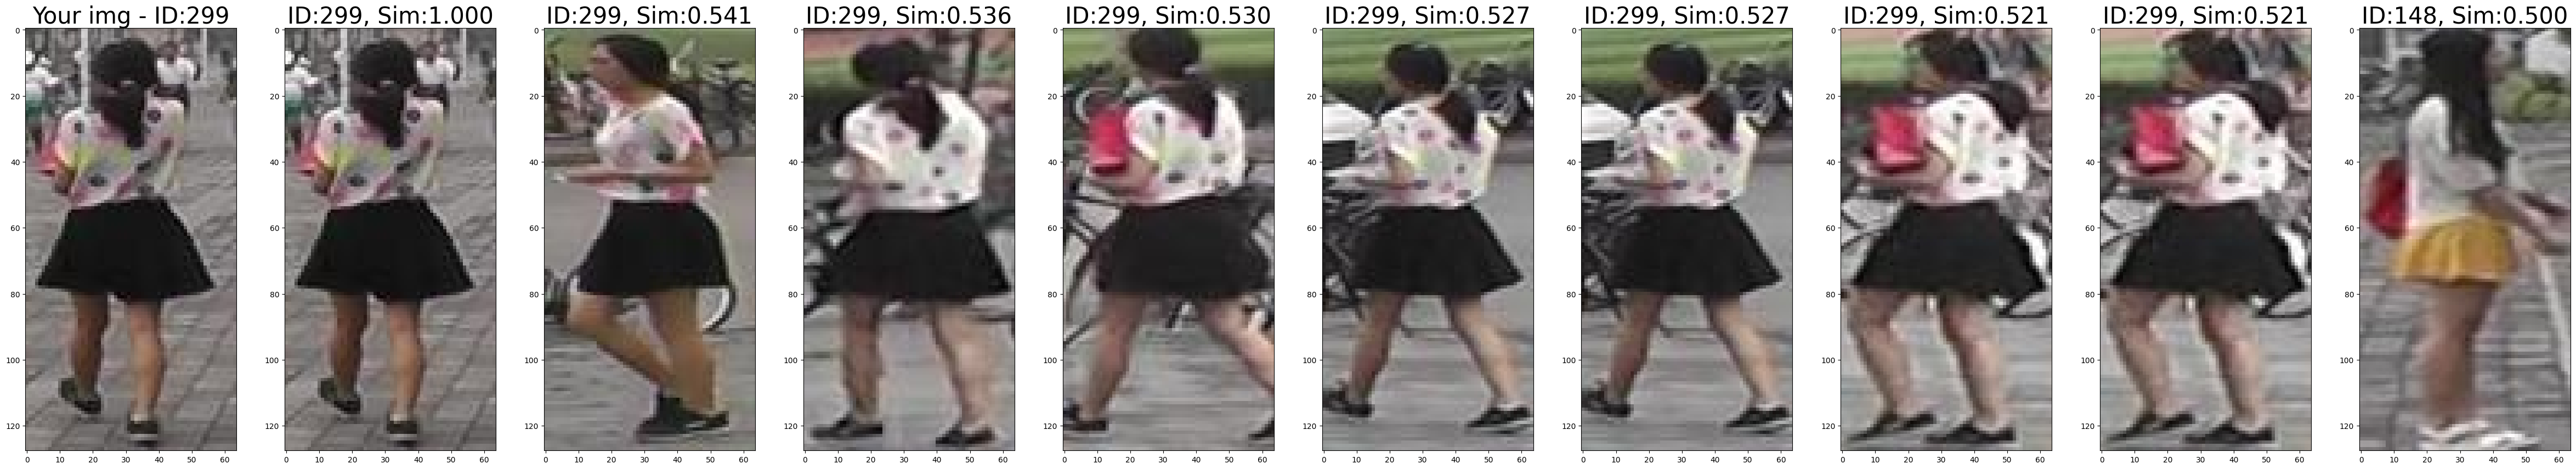

In [55]:
similar_images(idx=50, top_k=10)

Data Index: 250, Label: 139


,image_id,label,similarity
0,0139_c5s1_069023_01.jpg,139,1.000000
1,0139_c5s1_069073_01.jpg,139,0.644837
2,0139_c5s1_069373_02.jpg,139,0.632596
3,0139_c5s1_069323_02.jpg,139,0.616655
4,0139_c5s1_025351_05.jpg,139,0.600490
5,0139_c3s1_068767_01.jpg,139,0.590744
6,0022_c4s1_045251_01.jpg,22,0.557852
7,0299_c1s1_067306_02.jpg,299,0.554279
8,0139_c4s1_022751_05.jpg,139,0.544934
9,0139_c1s1_023301_02.jpg,139,0.540100


Out of top 10, 8 is the same label group.


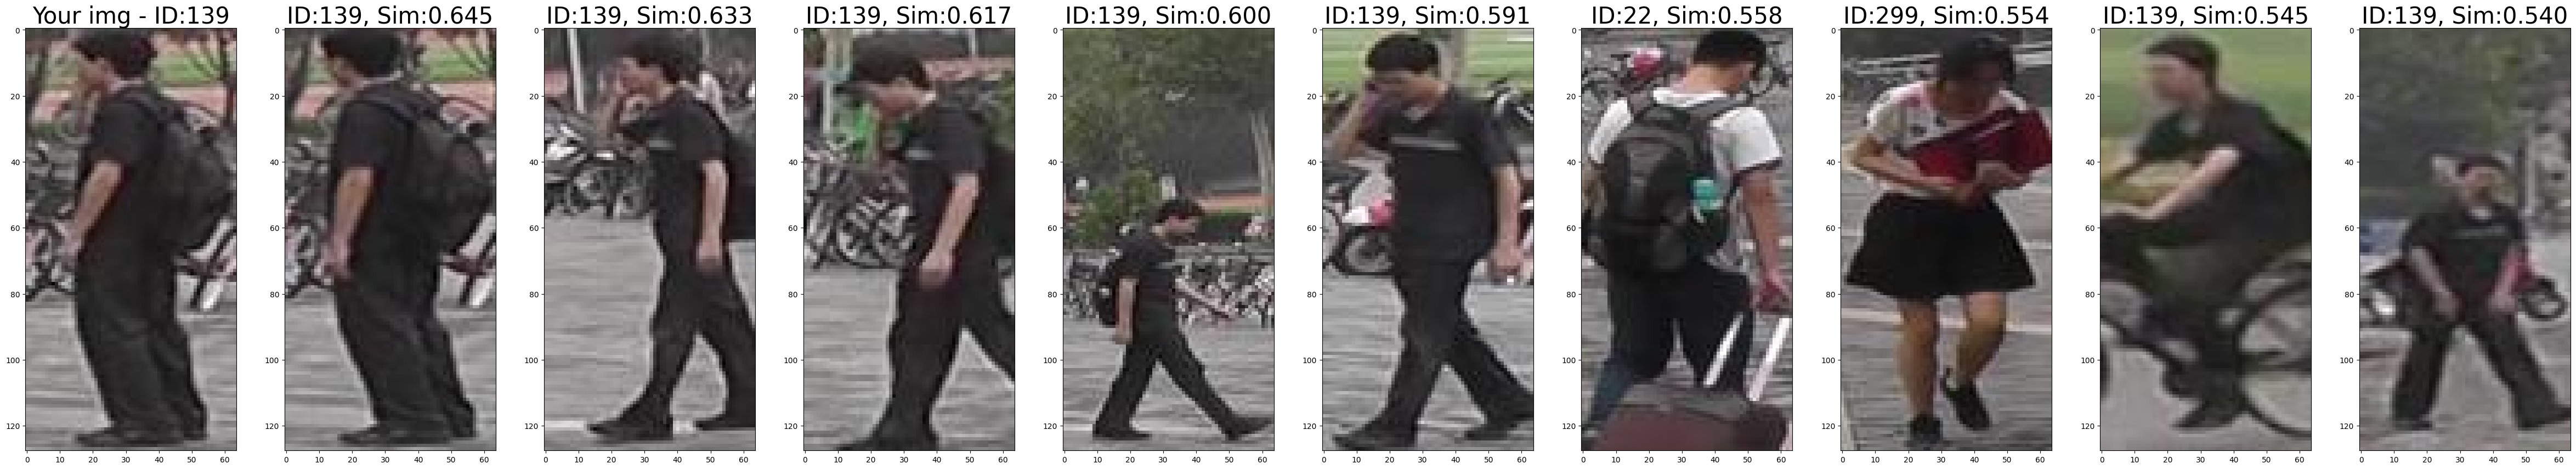

In [56]:
similar_images(idx=250, top_k=10)

Data Index: 330, Label: 261


,image_id,label,similarity
0,0261_c6s1_082326_03.jpg,261,1.000000
1,0105_c6s1_036876_02.jpg,105,0.725135
2,0261_c6s1_082301_03.jpg,261,0.696612
3,0105_c6s1_026751_01.jpg,105,0.678964
4,0261_c6s1_055876_01.jpg,261,0.673404
5,0105_c6s1_036276_01.jpg,105,0.666759
6,0261_c6s1_055901_02.jpg,261,0.641753
7,0105_c6s1_036776_01.jpg,105,0.635812
8,0105_c6s1_036676_01.jpg,105,0.629988
9,0105_c1s1_026351_01.jpg,105,0.610070


Out of top 10, 4 is the same label group.


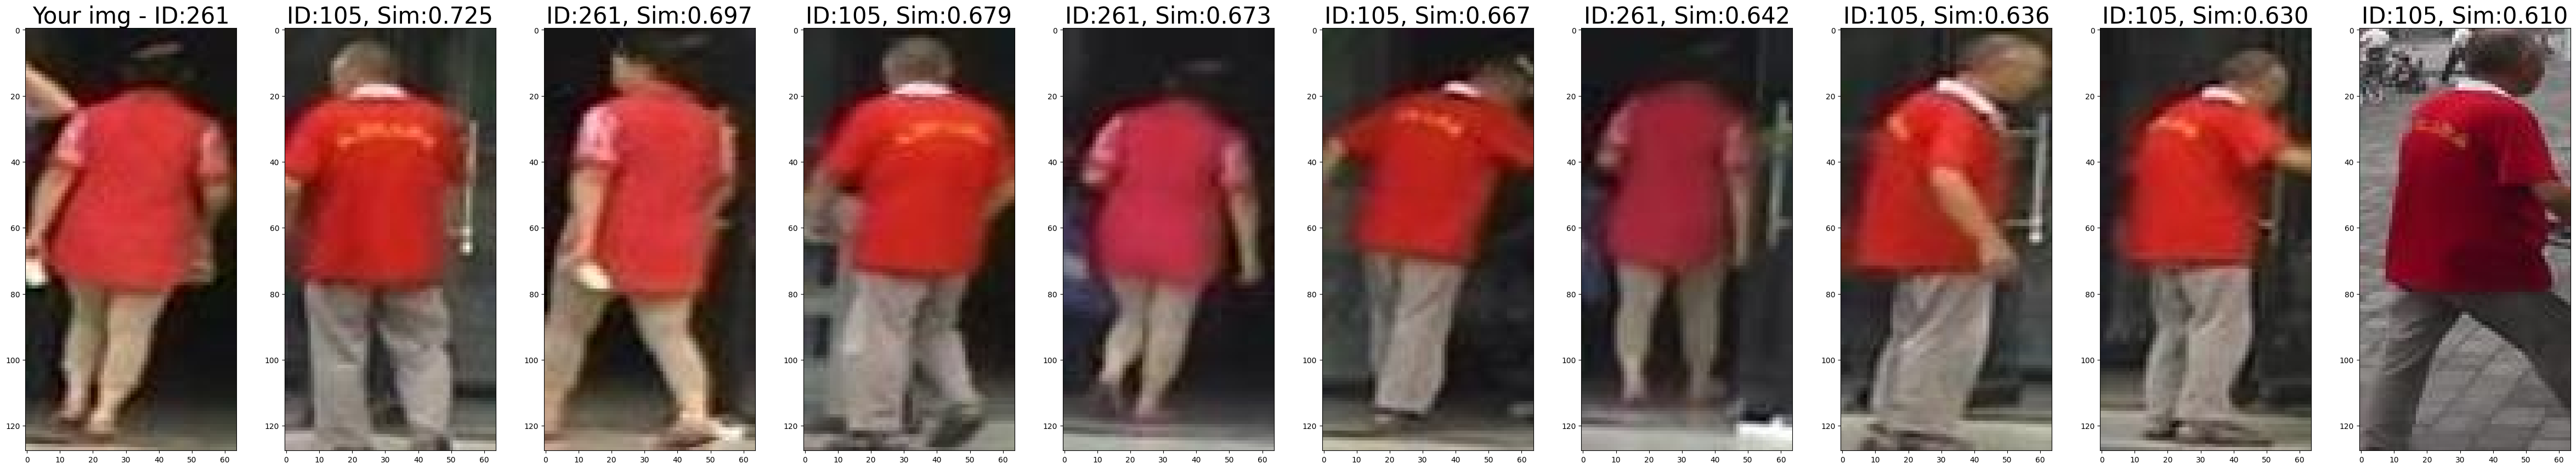

In [57]:
similar_images(idx=330, top_k=10)

Data Index: 400, Label: 197


,image_id,label,similarity
0,0197_c3s1_044551_02.jpg,197,1.000000
1,0197_c3s1_044551_02.jpg,197,1.000000
2,0197_c3s1_044601_01.jpg,197,0.660984
3,0197_c3s1_044601_01.jpg,197,0.660984
4,0197_c3s1_044676_02.jpg,197,0.611277
5,0197_c5s1_045026_03.jpg,197,0.605128
6,0197_c5s1_045026_03.jpg,197,0.605128
7,0197_c1s1_039301_01.jpg,197,0.600478
8,0197_c1s1_039301_01.jpg,197,0.600478
9,0148_c3s1_023926_03.jpg,148,0.596588


Out of top 10, 9 is the same label group.


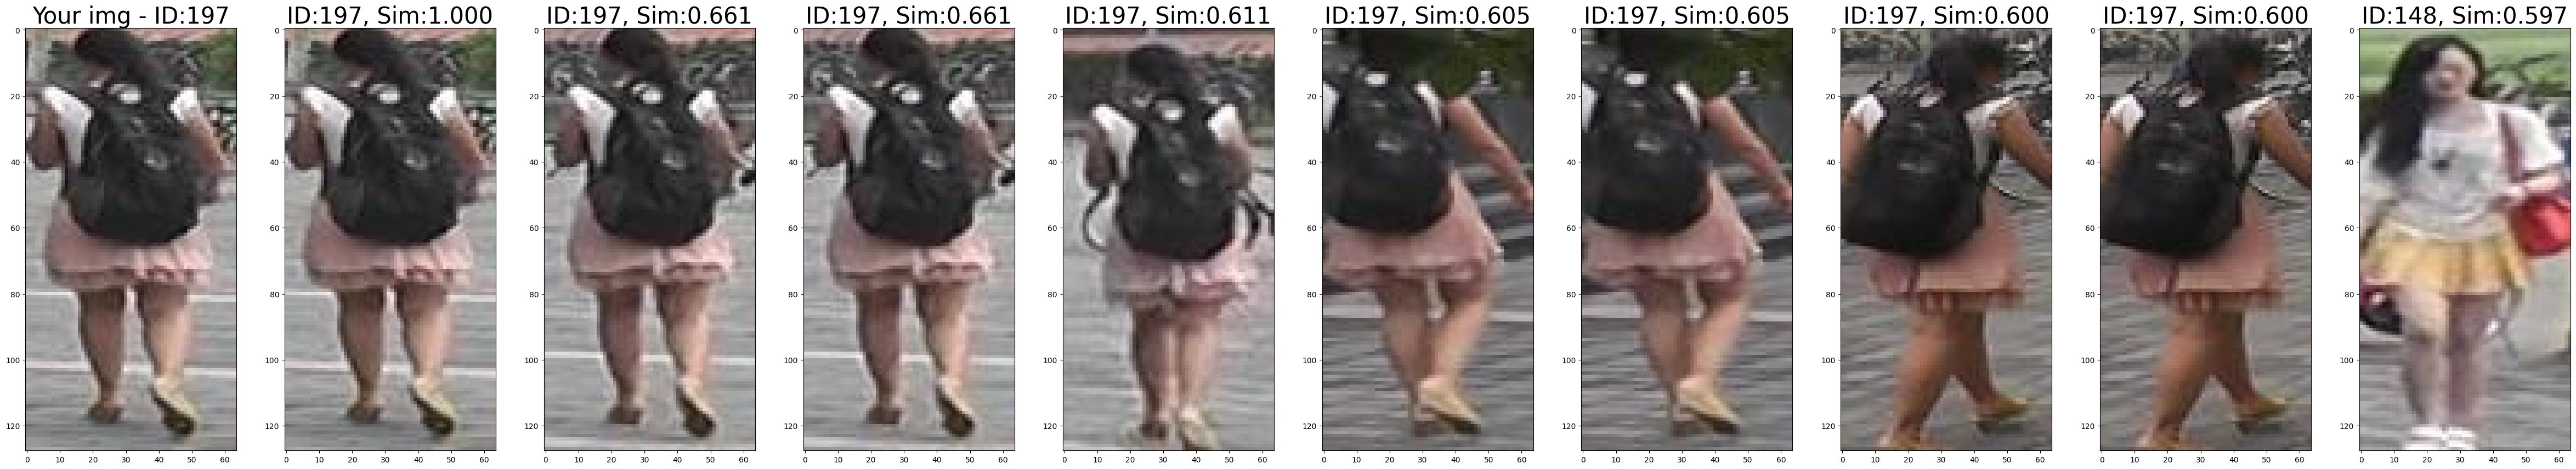

In [58]:
similar_images(idx=0, top_k=10)